In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import scanpy as sc
import scanpy.external as sce
from pygam import GAM, s
from scipy.ndimage import convolve
import collections
from concurrent.futures import ThreadPoolExecutor
import anndata as ad
from typing import Optional
import seaborn as sns
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def scale_distances(adata):
    scaler = MinMaxScaler()
    scaler.fit(adata.obs.closest_cyst_distance.values.reshape(-1,1))
    adata.obs.closest_cyst_distance = scaler.transform(adata.obs.closest_cyst_distance.values.reshape(-1,1))

def normalize(adata):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

In [5]:
adata_pkd_1 = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_1_visium_with_distances_and_areas.h5ad")
scale_distances(adata_pkd_1)
normalize(adata_pkd_1)
adata_pkd_2 = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_2_visium_with_distances_and_areas.h5ad")
scale_distances(adata_pkd_2)
normalize(adata_pkd_2)
adata_pkd_3 = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_3_visium_with_distances_and_areas.h5ad")
scale_distances(adata_pkd_3)
normalize(adata_pkd_3)

In [6]:
adatas = [adata_pkd_1, adata_pkd_2, adata_pkd_3]

In [7]:
adata = adatas[0].concatenate(
    adatas[1:3],
)

In [8]:
adata.obs.closest_cyst_distance

AAACAGAGCGACTCCT-1-pkd_1-0    0.021094
AAACCGGGTAGGTACC-1-pkd_1-0    0.344929
AAACCGTTCGTCCAGG-1-pkd_1-0    0.227147
AAACGAGACGGTTGAT-1-pkd_1-0    0.186314
AAACTCGGTTCGCAAT-1-pkd_1-0    0.032917
                                ...   
TTGTTGTGTGTCAAGA-1-pkd_3-2    0.698398
TTGTTTCACATCCAGG-1-pkd_3-2    0.049839
TTGTTTCATTAGTCTA-1-pkd_3-2    0.191813
TTGTTTCCATACAACT-1-pkd_3-2         NaN
TTGTTTGTGTAAATTC-1-pkd_3-2    0.183208
Name: closest_cyst_distance, Length: 6277, dtype: float64

In [9]:
adata = adata[np.isfinite(adata.obs.closest_cyst_distance.values)].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 6162 × 17628
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'clusters', 'clusters_0.7', 'S_score', 'G2M_score', 'phase', 'cell_types', 'closest_cyst_distance', 'closest_cyst_area', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'LogNorm', 'scaled'

In [11]:
import pickle

# Define the base directory where the files are stored
base_dir = '/exports/humgen/cnovellarausell/SevtapSpatial/'

# Define the different PKD versions you are interested in
pkds = ['pkd_1', 'pkd_2', 'pkd_3']

# Create dictionaries to store the data for models, predictions, and test sets
models_dict = {}
y_test_dict_all = {}
x_test_dict_all = {}

# Loop over each PKD version to load the respective files
for pkd in pkds:
    # Load the trained models
    model_path = f"{base_dir}Trained_models_max_distance_val_end_{pkd}_scaled.pkl"
    with open(model_path, 'rb') as handle:
        models_dict[pkd] = pickle.load(handle)

    # Load the predictions
    predictions_path = f"{base_dir}Trained_mdodels_predictions_max_distance_val_end_{pkd}_scaled.pkl"
    with open(predictions_path, 'rb') as handle:
        y_test_dict_all[pkd] = pickle.load(handle)

    # Load the X test data
    x_test_path = f"{base_dir}Trained_mdodels_x_test_max_distance_val_end_{pkd}_scaled.pkl"
    with open(x_test_path, 'rb') as handle:
        x_test_dict_all[pkd] = pickle.load(handle)

In [12]:
def get_top_genes(y_test_dict, adata, n_top=100):
    y_test_df = pd.DataFrame.from_dict(y_test_dict)
    trends = sc.AnnData(y_test_df.T)  # Transpose to make genes as observations
    trends.obs_names = y_test_df.columns
    cols = ["means", "dispersions"]
    trends.obs = trends.obs.merge(
        right=adata.var[cols], how="left", left_index=True, right_index=True
    )

    first_state = trends.X[:, 0]
    last_state = trends.X[:, -1]
    abs_change = np.abs(first_state - last_state)
    change = first_state - last_state
    # Add this as a column in the .obs DataFrame
    trends.obs['abs_change'] = abs_change
    trends.obs['change'] = change
    # compute change at every point and store in a layer
    trends.layers['point_delta'] = np.diff(trends.X, axis=1, prepend=trends.X[:, 0:1])
    trends.layers['point_abs_delta'] = np.abs(np.diff(trends.X, axis=1, prepend=trends.X[:, 0:1]))
    trends.obs['first20_abs_delta'] = np.sum(trends.layers['point_abs_delta'][:, :20], axis=1)
    trends.obs['first20_delta'] = np.sum(trends.layers['point_delta'][:, :20], axis=1)
    trends.obs['first10_abs_delta'] = np.sum(trends.layers['point_abs_delta'][:, :10], axis=1)
    trends.obs['last190_abs_delta'] = np.sum(trends.layers['point_abs_delta'][:, 10:], axis=1)
    trends.obs['first10_delta'] = np.sum(trends.layers['point_delta'][:, :10], axis=1)
    trends.obs['last190_delta'] = np.sum(trends.layers['point_delta'][:, 10:], axis=1)
    trends.obs['last190_mean'] = np.mean(trends.X[:, 10:], axis=1)
    trends.obs['close_peak'] = trends.obs['first10_delta'] + trends.obs['last190_abs_delta'] #-|Delta1| 


    
    # Sort and get top genes
    sorted_genes = trends.obs.sort_values('first10_delta', ascending=True).head(n_top).sort_values('last190_abs_delta', ascending=True, key=abs).head(n_top).index
    # specific  trends.obs.sort_values(['first10_abs_delta'], ascending=[False]).head(100).sort_values("means", ascending=True).head(n_top).index
    # stable trends.obs.sort_values('first10_delta', ascending=True).head(n_top).sort_values('last190_abs_delta', ascending=True, key=abs).head(n_top).index
    return sorted_genes



def plot_genes(dataset_name, gene_set, y_test_dict, adata):
    selected_genes = sorted(list(gene_set))  # sorted list of unique genes
    genes_per_group = 20  # Number of genes per plot group
    n_cols = 3  # Fixed number of columns

    if len(selected_genes) == 0:
        print(f"No unique genes to plot for {dataset_name}.")
        return

    # Define a color palette for the plots
    colors = sns.color_palette('tab10', n_colors=3)  # 'husl' is vibrant; adjust the palette as needed

    # Calculate the number of rows needed for the subplots
    n_rows = (len(selected_genes) + n_cols - 1) // n_cols  # Ceiling division for rows

    # Create the figure with the calculated number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows * n_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easy iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, gene in enumerate(selected_genes):
        ax = axes[i]  # Get the current axis for the gene

        # Plot predictions for the specific dataset
        if gene in y_test_dict[dataset_name]:
            x_pred = np.linspace(0, 1, len(y_test_dict[dataset_name][gene]))  # Assuming evenly spaced predictions
            sns.lineplot(x=x_pred, y=y_test_dict[dataset_name][gene], ax=ax, label=f'{dataset_name} Predicted', color=colors[int(str(dataset_name).split('_')[1]) - 1])

        # # Actual gene expression data plot
        # if gene in adata.var_names:
        #     gene_expression = adata[:, gene].X.flatten()
        #     distances = adata[:, gene].obs['closest_cyst_distance'].values
        #     sns.scatterplot(x=distances, y=gene_expression, ax=ax, color='red', s=10, label='Actual', alpha=0.6)

        sns.despine()
        ax.set_title(gene)
        ax.set_ylabel('Expression')
        ax.set_xlabel('Distance to cyst')
        ax.legend()

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  # Turn off any remaining axes not used

    plt.tight_layout()
    plt.show()

In [13]:
# Assuming y_test_dict_all contains all prediction dictionaries for pkd_1, pkd_2, pkd_3
top_genes_pkd1 = get_top_genes(y_test_dict_all['pkd_1'], adata)
top_genes_pkd2 = get_top_genes(y_test_dict_all['pkd_2'], adata)
top_genes_pkd3 = get_top_genes(y_test_dict_all['pkd_3'], adata)

# Convert to sets if not already
set_genes_pkd1 = set(top_genes_pkd1)
set_genes_pkd2 = set(top_genes_pkd2)
set_genes_pkd3 = set(top_genes_pkd3)

# Find the intersection of top genes across all datasets
common_genes = set_genes_pkd1.intersection(set_genes_pkd2, set_genes_pkd3)

# Find genes unique to pkd_1 (present in pkd_1 but not in pkd_2 and pkd_3)
unique_genes_pkd1 = set_genes_pkd1 - (set_genes_pkd2.union(set_genes_pkd3))

# Find genes unique to pkd_2 (present in pkd_2 but not in pkd_1 and pkd_3)
unique_genes_pkd2 = set_genes_pkd2 - (set_genes_pkd1.union(set_genes_pkd3))

# Find genes unique to pkd_3 (present in pkd_3 but not in pkd_1 and pkd_2)
unique_genes_pkd3 = set_genes_pkd3 - (set_genes_pkd1.union(set_genes_pkd2))

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
common_genes

{'Anxa2',
 'Apoe',
 'Arpc1b',
 'B2m',
 'Bgn',
 'C1qa',
 'C1qb',
 'C1qc',
 'Cd52',
 'Cd74',
 'Cfh',
 'Clu',
 'Col1a1',
 'Col1a2',
 'Col3a1',
 'Crip1',
 'Cryab',
 'Ctss',
 'Cxcl16',
 'Dynll1',
 'Fcer1g',
 'Fn1',
 'H2-Aa',
 'H2-Ab1',
 'H2-Eb1',
 'H2-K1',
 'Lcn2',
 'Lgals1',
 'Lyz2',
 'Mgp',
 'Mid1ip1',
 'Ptgds',
 'Rbp1',
 'S100a10',
 'S100a11',
 'S100a6',
 'Serping1',
 'Sparc',
 'Timp2',
 'Tmsb10',
 'Tmsb4x',
 'Tspan8',
 'Tuba1a',
 'Tyrobp',
 'Vim'}

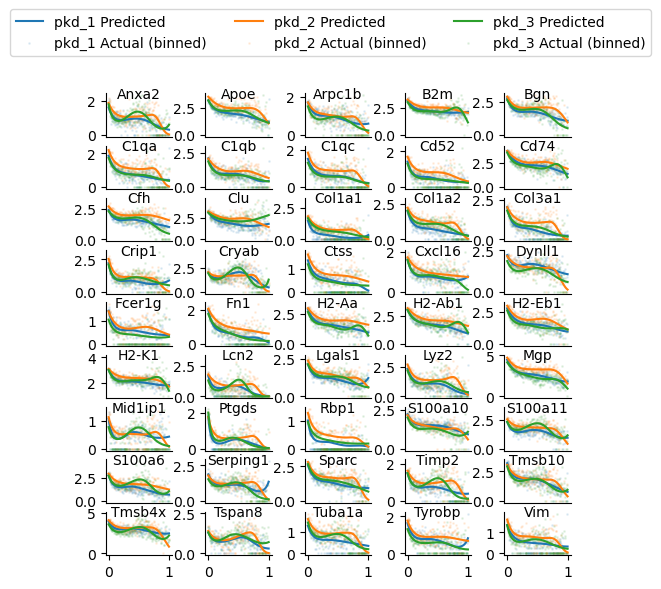

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic

selected_genes = sorted(list(common_genes))  # sorted list of common genes
genes_per_group = 45  # Number of genes per plot group

for group_index, group_start in enumerate(range(0, len(selected_genes), genes_per_group)):
    current_group_genes = selected_genes[group_start:group_start + genes_per_group]
    
    fig, axes = plt.subplots(9, 5, figsize=(6,6))  # Increased figsize for better visibility
    axes = axes.flatten()
    
    for i, gene in enumerate(current_group_genes):
        ax = axes[i]
        
        for pkd, color in zip(['pkd_1', 'pkd_2', 'pkd_3'], ['blue', 'green', 'purple']):
            # Plot predictions
            x_pred = np.linspace(0, 1, len(y_test_dict_all[pkd][gene]))
            y_pred = y_test_dict_all[pkd][gene]
    
            ax.plot(x_pred, y_pred,  label=f'{pkd} Predicted', linewidth=1.5)
            
            # Plot actual data
            # gene_expression = adata[adata.obs.library_id==pkd][:, gene].X.A.reshape(-1,)
            # distances = adata[adata.obs.library_id==pkd][:, gene].obs['closest_cyst_distance'].values
            # Bin the actual data
            # bins = np.linspace(0, 1, 200)
            # binned_expression, _, _ = binned_statistic(distances, gene_expression, statistic='median', bins=bins)
            # bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # ax.scatter(bin_centers, binned_expression,  s=1, alpha=0.1, label=f'{pkd} Actual (binned)')
        
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
        sns.despine()
        # Turn off x-axis labels and ticks for all but the last row
        if (i // 5) != 8:  # Only the last row index (i // 5 == 8 for 9 rows and zero-index)
            ax.set_xticklabels([])
            ax.set_xlabel('')
            ax.xaxis.set_ticks_position('none')
        ax.set_title(gene, fontdict={'fontsize': 10}, y=0.7)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    handles, labels = axes[i].get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, borderaxespad=0.)
    plt.show()

In [17]:
import decoupler as dc

In [18]:
selected_genes = sorted(list(common_genes))  # sorted list of common genes

signature = pd.DataFrame(selected_genes, columns=["target"])
signature["source"] = 'Cystic genes'

In [19]:
dc.run_ora(
    mat=adata,
    net=signature,
    source='source',
    target='target',
    verbose=True
)

Running ora on mat with 6162 samples and 17628 targets for 1 sources.


100%|██████████| 6162/6162 [00:05<00:00, 1167.62it/s]


In [20]:
adata.obsm['ora_estimate']

source,Cystic genes
AAACAGAGCGACTCCT-1-pkd_1-0,7.366913
AAACCGGGTAGGTACC-1-pkd_1-0,6.424775
AAACCGTTCGTCCAGG-1-pkd_1-0,23.359751
AAACGAGACGGTTGAT-1-pkd_1-0,11.573330
AAACTCGGTTCGCAAT-1-pkd_1-0,42.286541
...,...
TTGTTCAGTGTGCTAC-1-pkd_3-2,4.684685
TTGTTGTGTGTCAAGA-1-pkd_3-2,5.529909
TTGTTTCACATCCAGG-1-pkd_3-2,36.551506
TTGTTTCATTAGTCTA-1-pkd_3-2,17.737297


In [21]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

In [22]:
acts.var_names

Index(['Cystic genes'], dtype='object', name='source')

In [23]:
acts.obsm['spatial'] = adata.obsm['spatial']

In [24]:
adata.obsm['spatial']

array([[ 4399,  6102],
       [ 9984, 13566],
       [11951, 11963],
       ...,
       [13729, 11636],
       [14134, 12997],
       [ 3638, 10686]])

In [25]:
import matplotlib.colors as mcolors
tab10_colors = sns.color_palette("tab10", 10)  # tab10 has 10 colors
def create_sequential_colormap(color):
    """Creates a sequential colormap from a given RGB color."""
    # Create a color map that interpolates between white and the given color
    colors = [(1, 1, 1), color]  # from white to the color
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_seq_cmap", colors)
    return cmap

# Create a dictionary to hold the colormaps
sequential_colormaps = {f'tab10_seq_{i}': create_sequential_colormap(color) for i, color in enumerate(tab10_colors)}

In [26]:
sequential_colormaps

{'tab10_seq_0': <matplotlib.colors.LinearSegmentedColormap at 0x7fa9974c00d0>,
 'tab10_seq_1': <matplotlib.colors.LinearSegmentedColormap at 0x7fa99d070050>,
 'tab10_seq_2': <matplotlib.colors.LinearSegmentedColormap at 0x7fa997553290>,
 'tab10_seq_3': <matplotlib.colors.LinearSegmentedColormap at 0x7fa99d128210>,
 'tab10_seq_4': <matplotlib.colors.LinearSegmentedColormap at 0x7fa999f56610>,
 'tab10_seq_5': <matplotlib.colors.LinearSegmentedColormap at 0x7fa997427b90>,
 'tab10_seq_6': <matplotlib.colors.LinearSegmentedColormap at 0x7fa997430e90>,
 'tab10_seq_7': <matplotlib.colors.LinearSegmentedColormap at 0x7fa9973f0ed0>,
 'tab10_seq_8': <matplotlib.colors.LinearSegmentedColormap at 0x7fa99d06f4d0>,
 'tab10_seq_9': <matplotlib.colors.LinearSegmentedColormap at 0x7fa99d06ca10>}

[<Axes: title={'center': 'Cystic genes'}, xlabel='spatial1', ylabel='spatial2'>]

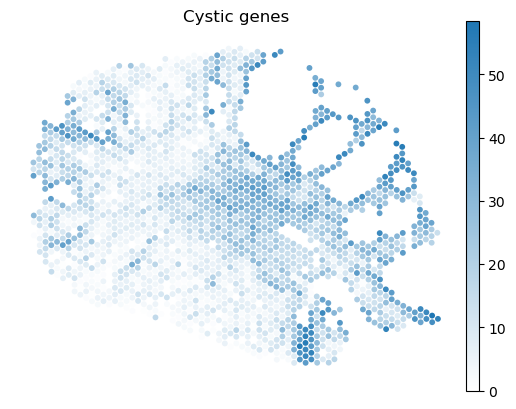

In [28]:
sc.pl.spatial(
    acts[acts.obs.library_id=='pkd_1'],
    color=['Cystic genes'],
    cmap=sequential_colormaps['tab10_seq_0'],
    spot_size=200,
    frameon=False,
    show=False
)
#plt.savefig('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Gene_trends_to_cyst/Scaled_distances_together/Matching_trends_ORA_plot_pkd_1.pdf', bbox_inches='tight')

[<Axes: title={'center': 'Cystic genes'}, xlabel='spatial1', ylabel='spatial2'>]

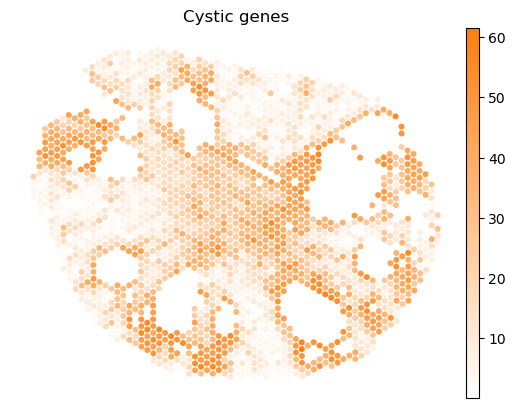

In [29]:
sc.pl.spatial(
    acts[acts.obs.library_id=='pkd_2'],
    color=['Cystic genes'],
    cmap=sequential_colormaps['tab10_seq_1'],
    spot_size=200,
    frameon=False,
    show=False,
)
#plt.savefig('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Gene_trends_to_cyst/Scaled_distances_together/Matching_trends_ORA_plot_pkd_2.pdf', bbox_inches='tight')

[<Axes: title={'center': 'Cystic genes'}, xlabel='spatial1', ylabel='spatial2'>]

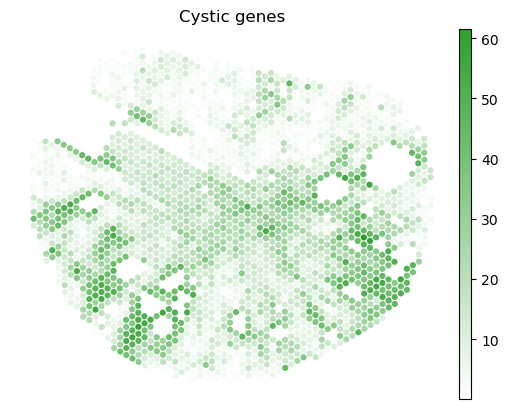

In [30]:
sc.pl.spatial(
    acts[acts.obs.library_id=='pkd_3'],
    color=['Cystic genes'],
    cmap=sequential_colormaps['tab10_seq_2'],
    spot_size=200,
    frameon=False,
    show=False
)
#plt.savefig('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Gene_trends_to_cyst/Scaled_distances_together/Matching_trends_ORA_plot_pkd_3.pdf', bbox_inches='tight')

In [279]:
acts[acts.obs.library_id=='pkd_3'].obs_names

Index(['AAACCGGGTAGGTACC-1-pkd_3-2', 'AAACCGTTCGTCCAGG-1-pkd_3-2',
       'AAACCTAAGCAGCCGG-1-pkd_3-2', 'AAACCTCATGAAGTTG-1-pkd_3-2',
       'AAACGAAGAACATACC-1-pkd_3-2', 'AAACGAGACGGTTGAT-1-pkd_3-2',
       'AAACGGTTGCGAACTG-1-pkd_3-2', 'AAACTCGGTTCGCAAT-1-pkd_3-2',
       'AAACTGCTGGCTCCAA-1-pkd_3-2', 'AAACTTGCAAACGTAT-1-pkd_3-2',
       ...
       'TTGTGGCCCTGACAGT-1-pkd_3-2', 'TTGTGGTAGGAGGGAT-1-pkd_3-2',
       'TTGTGTATGCCACCAA-1-pkd_3-2', 'TTGTGTTTCCCGAAAG-1-pkd_3-2',
       'TTGTTAGCAAATTCGA-1-pkd_3-2', 'TTGTTCAGTGTGCTAC-1-pkd_3-2',
       'TTGTTGTGTGTCAAGA-1-pkd_3-2', 'TTGTTTCACATCCAGG-1-pkd_3-2',
       'TTGTTTCATTAGTCTA-1-pkd_3-2', 'TTGTTTGTGTAAATTC-1-pkd_3-2'],
      dtype='object', length=2193)

In [31]:
pkd_3_acts = acts[acts.obs.library_id=='pkd_3'].copy()
pkd_2_acts = acts[acts.obs.library_id=='pkd_2'].copy()
pkd_1_acts = acts[acts.obs.library_id=='pkd_1'].copy()

In [32]:
pkd_3_acts.obs_names = pkd_3_acts.obs_names.str.split('-').str[0]
pkd_2_acts.obs_names = pkd_2_acts.obs_names.str.split('-').str[0]
pkd_1_acts.obs_names = pkd_1_acts.obs_names.str.split('-').str[0]

In [33]:
pkd_1_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_1_tangram_segmented_nuclei_data_withPKD.csv")
pkd_2_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_2_tangram_segmented_nuclei_data_withPKD.csv")
pkd_3_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_3_tangram_segmented_nuclei_data_withPKD.csv")

In [34]:
pkd_1_segmented_data.centroids = pkd_1_segmented_data.centroids.str.split('-').str[0]
pkd_2_segmented_data.centroids = pkd_2_segmented_data.centroids.str.split('-').str[0]
pkd_3_segmented_data.centroids = pkd_3_segmented_data.centroids.str.split('-').str[0]

In [37]:
pkd_1_segmented_data['cluster'].unique()

array(['PTS3', 'PTS1', 'PTS2', 'PT-Inj', 'DCT', 'Macro',
       'Gzma+ CD8+ T lymph', 'Endo', 'CNT', 'B lymph', 'Myofib',
       'CD4+ T lymph', 'TAL', 'NKT1', 'PTS3T2', 'PC',
       'Spp1+ Resident Macrophages ', 'PT-FR', 'Fib', 'Memory B lymph',
       'LOH', 'CD4+ Th17', 'ICA', 'T3/Follicular B lymph', 'T lymph',
       'Trans-PTC', 'DTL', 'DC', 'Per', 'Lyc6 low Macrophages', 'ICB',
       'ATL', 'CD-Trans', 'Gzma+ NK', 'PEC', 'Podo', 'Glom-Endo',
       'DCT-CNT', 'T1 B lymph', 'Lyc6 high Macrophages', 'DTL-ATL',
       'Gzma low NK', 'PT-AcInj', 'PT-R', 'MD',
       'Mrc1+ Resident Macrophages', 'Neutro', 'B1 B lymph',
       'CD4+ T regs', 'NK'], dtype=object)

In [38]:
low_res = {
    'Macro': ['Lyc6 low Macrophages', 'Lyc6 high Macrophages','Spp1+ Resident Macrophages ', 'Mrc1+ Resident Macrophages'],
    'NK': ['Gzma+ NK', 'Gzma low NK', 'NKT1', 'Gzma+ NK'],
    'B lymph': ['B1 B lymph', 'B1 B lymph', 'T3/Follicular B lymph', 'T1 B lymph', 'Memory B lymph'],
    'T lymph': ['CD4+ Th17', 'CD4+ T regs', 'Gzma+ CD8+ T lymph', 'CD4+ T lymph']}
low_res_rev = {vs: k for k, v in low_res.items() for vs in v}
pkd_1_segmented_data['cluster'] = pkd_1_segmented_data['cluster'].replace(low_res_rev)
pkd_2_segmented_data['cluster'] = pkd_2_segmented_data['cluster'].replace(low_res_rev)
pkd_3_segmented_data['cluster'] = pkd_3_segmented_data['cluster'].replace(low_res_rev)

In [39]:
def process_anndata_and_compute_correlations(activities, segmented_data, adata_name):
    # Load the AnnData object
    adata = activities.copy()

    # Load the DataFrame
    df = segmented_data.copy()

    # Compute the percentage of each cell type per unique centroid
    grouped = df.groupby(['centroids', 'cluster']).size().reset_index(name='counts')
    total_counts = grouped.groupby('centroids')['counts'].transform('sum')
    grouped['percentage'] = grouped['counts'] / total_counts * 100
    percentage_df = grouped.pivot(index='centroids', columns='cluster', values='percentage').fillna(0)

    # Align the percentage dataframe with the AnnData object
    adata_centroids = adata.obs_names.to_list()
    centroid_percentage_df = percentage_df.reindex(adata_centroids).fillna(0)
    
    # Add the percentages to the AnnData object's obs attribute
    for column in centroid_percentage_df.columns:
        adata.obs[f'percentage_{column}'] = centroid_percentage_df[column].values

    # Step 3: Extract the feature values from .X
    feature_values = adata.X[:, 0].flatten()  # Assuming there's only one feature and it's in the first column

    # Extract the percentage columns
    percentage_columns = [col for col in adata.obs.columns if col.startswith('percentage_')]
    percentage_df = adata.obs[percentage_columns]

    # Calculate the correlation between the feature and each cell type percentage
    correlation_results = {
        'cell_type': [],
        'correlation': [],
        'p_value': [],
        'dataset': []
    }

    for col in percentage_columns:
        correlation, p_value = pearsonr(feature_values, adata.obs[col].values)
        correlation_results['cell_type'].append(col.split('_')[1])
        correlation_results['correlation'].append(correlation)
        correlation_results['p_value'].append(p_value)
        correlation_results['dataset'].append(adata_name)
    
    # Return both the modified AnnData object and the correlation results as a DataFrame
    return adata, pd.DataFrame(correlation_results)


    cell_type  correlation        p_value dataset
0         ATL     0.098411   1.253819e-05   pkd_1
1     B lymph    -0.089353   7.362570e-05   pkd_1
2    CD-Trans     0.073244   1.164597e-03   pkd_1
3         CNT    -0.046100   4.112362e-02   pkd_1
4          DC     0.135507   1.662789e-09   pkd_1
5         DCT    -0.185931   9.973856e-17   pkd_1
6     DCT-CNT    -0.088347   8.874924e-05   pkd_1
7         DTL     0.218683   1.108140e-22   pkd_1
8     DTL-ATL     0.086673   1.206047e-04   pkd_1
9        Endo     0.148489   3.807285e-11   pkd_1
10        Fib     0.289177   4.034007e-39   pkd_1
11  Glom-Endo    -0.001124   9.603232e-01   pkd_1
12        ICA    -0.030934   1.706891e-01   pkd_1
13        ICB    -0.031387   1.644997e-01   pkd_1
14        LOH     0.132718   3.579387e-09   pkd_1
15         MD     0.040062   7.597278e-02   pkd_1
16      Macro     0.530388  7.392230e-143   pkd_1
17     Myofib     0.196492   1.550228e-18   pkd_1
18         NK     0.215365   4.949423e-22   pkd_1


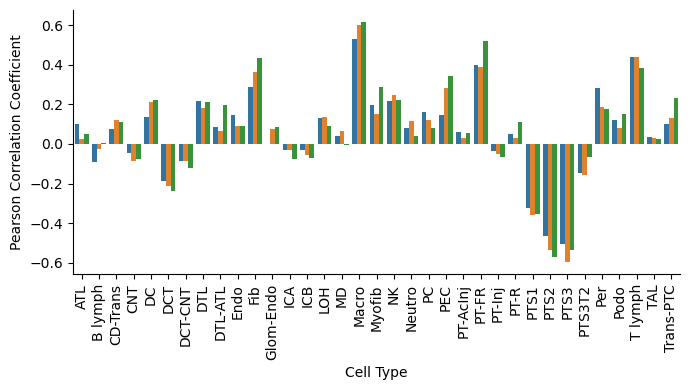

In [41]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr

# Aggregate correlation results from all datasets
all_correlations = pd.DataFrame()
activities_list = [pkd_1_acts, pkd_2_acts, pkd_3_acts]
segmented_data_list = [pkd_1_segmented_data, pkd_2_segmented_data, pkd_3_segmented_data]
segmented_data_list_with_new_annot = []
for activity, segmented_data, adata_name in zip(activities_list, segmented_data_list, ['pkd_1', 'pkd_2', 'pkd_3']):
    adata, correlation_df = process_anndata_and_compute_correlations(activity, segmented_data, adata_name)
    print(correlation_df)
    segmented_data_list_with_new_annot.append(adata)
    all_correlations = pd.concat([all_correlations, correlation_df], ignore_index=True)

# Apply Benjamini-Hochberg correction for multiple testing
p_values = all_correlations['p_value'].values
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.01)

# Add the corrected p-values to the DataFrame
all_correlations['p_value_corrected'] = pvals_corrected
all_correlations['significant'] = reject


# Separate significant and non-significant correlations
significant_correlations = all_correlations[all_correlations['significant']]
non_significant_correlations = all_correlations[~all_correlations['significant']]


# Plot significant correlations with solid bars
plt.figure(figsize=(7, 4))
sns.barplot(x='cell_type', y='correlation', hue='dataset', data=all_correlations)



plt.xticks(rotation=90)
plt.xlabel('Cell Type')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend([], [], frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Gene_trends_to_cyst/Cystic_gene_signature_cell_type_all_correlations_withPKD.pdf')
plt.show()

In [402]:
all_data = []

for activity, segmented_data, adata_name in zip(activities_list, segmented_data_list, ['pkd_1', 'pkd_2', 'pkd_3']):    
    correlation_df = process_anndata_and_compute_correlations(activity, segmented_data, adata_name)
    all_correlations = pd.concat([all_correlations, correlation_df], ignore_index=True)

    # Load the AnnData object and DataFrame again to get the full data
    adata = activity.copy()
    df = segmented_data.copy()
    
    # Add dataset name to DataFrame
    df['dataset'] = adata_name
    
    # Merge percentages into the DataFrame
    grouped = df.groupby(['centroids', 'cluster']).size().reset_index(name='counts')
    total_counts = grouped.groupby('centroids')['counts'].transform('sum')
    grouped['percentage'] = grouped['counts'] / total_counts * 100
    percentage_df = grouped.pivot(index='centroids', columns='cluster', values='percentage').fillna(0)
    centroid_percentage_df = percentage_df.reindex(adata.obs_names.to_list()).fillna(0)
    for column in centroid_percentage_df.columns:
        adata.obs[f'percentage_{column}'] = centroid_percentage_df[column].values
    
    # Extract PT-Inj data
    pt_inj_data = pd.DataFrame({
        'feature_value': adata.X[:, 0].flatten(),
        'percentage_Macro': adata.obs['percentage_Macro'],
        'dataset': adata_name
    })
    all_data.append(pt_inj_data)

# Concatenate all PT-Inj data
all_pt_inj_data = pd.concat(all_data, ignore_index=True)

In [77]:
pkd_1_with_distances = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_1_segment_with_distances_withPKD.h5ad")
scale_distances(pkd_1_with_distances)
pkd_2_with_distances = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_2_segment_with_distances_withPKD.h5ad")
scale_distances(pkd_2_with_distances)
pkd_3_with_distances = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/pkd_3_segment_with_distances_withPKD.h5ad")
scale_distances(pkd_3_with_distances)

In [75]:
low_res = {
    'Macro': ['Lyc6 low Macrophages', 'Lyc6 high Macrophages','Spp1+ Resident Macrophages ', 'Mrc1+ Resident Macrophages'],
    'NK': ['Gzma+ NK', 'Gzma low NK', 'NKT1', 'Gzma+ NK'],
    'B lymph': ['B1 B lymph', 'B1 B lymph', 'T3/Follicular B lymph', 'T1 B lymph', 'Memory B lymph'],
    'T lymph': ['CD4+ Th17', 'CD4+ T regs', 'Gzma+ CD8+ T lymph', 'CD4+ T lymph']}
low_res_rev = {vs: k for k, v in low_res.items() for vs in v}

In [81]:
pkd_1_with_distances.obs['cluster'] = pkd_1_with_distances.obs.cluster.replace(low_res_rev)
pkd_2_with_distances.obs['cluster'] = pkd_2_with_distances.obs.cluster.replace(low_res_rev)
pkd_3_with_distances.obs['cluster'] = pkd_3_with_distances.obs.cluster.replace(low_res_rev)

In [82]:
pkd_1_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_1_tangram_segmented_nuclei_data_withPKD.csv")
pkd_2_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_2_tangram_segmented_nuclei_data_withPKD.csv")
pkd_3_segmented_data = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/pkd_3_tangram_segmented_nuclei_data_withPKD.csv")

In [83]:
low_res = {
    'Macro': ['Lyc6 low Macrophages', 'Lyc6 high Macrophages','Spp1+ Resident Macrophages ', 'Mrc1+ Resident Macrophages'],
    'NK': ['Gzma+ NK', 'Gzma low NK', 'NKT1', 'Gzma+ NK'],
    'B lymph': ['B1 B lymph', 'B1 B lymph', 'T3/Follicular B lymph', 'T1 B lymph', 'Memory B lymph'],
    'T lymph': ['CD4+ Th17', 'CD4+ T regs', 'Gzma+ CD8+ T lymph', 'CD4+ T lymph']}
low_res_rev = {vs: k for k, v in low_res.items() for vs in v}
pkd_1_segmented_data['cluster'] = pkd_1_segmented_data['cluster'].replace(low_res_rev)
pkd_2_segmented_data['cluster'] = pkd_2_segmented_data['cluster'].replace(low_res_rev)
pkd_3_segmented_data['cluster'] = pkd_3_segmented_data['cluster'].replace(low_res_rev)

In [84]:
pkd_1_cluster_distance_to_cyst = pkd_1_with_distances.obs.groupby('cluster')['closest_cyst_distance'].apply('median')
pkd_2_cluster_distance_to_cyst = pkd_2_with_distances.obs.groupby('cluster')['closest_cyst_distance'].apply('median')
pkd_3_cluster_distance_to_cyst = pkd_3_with_distances.obs.groupby('cluster')['closest_cyst_distance'].apply('median')

In [85]:
pkd_1_cluster_abundance = pkd_1_with_distances.obs.cluster.value_counts(normalize=True)
pkd_2_cluster_abundance = pkd_2_with_distances.obs.cluster.value_counts(normalize=True)
pkd_3_cluster_abundance = pkd_3_with_distances.obs.cluster.value_counts(normalize=True)

In [86]:
# Create DataFrames from each series
pkd_1_df = pd.DataFrame(pkd_1_cluster_abundance).reset_index()
pkd_1_df['dataset'] = 'pkd_1'

pkd_2_df = pd.DataFrame(pkd_2_cluster_abundance).reset_index()
pkd_2_df['dataset'] = 'pkd_2'

pkd_3_df = pd.DataFrame(pkd_3_cluster_abundance).reset_index()
pkd_3_df['dataset'] = 'pkd_3'

# Rename 'index' column to 'cell_type'
pkd_1_df.rename(columns={'index': 'cell_type', 'cluster': 'cell_type'}, inplace=True)
pkd_2_df.rename(columns={'index': 'cell_type', 'cluster': 'cell_type'}, inplace=True)
pkd_3_df.rename(columns={'index': 'cell_type', 'cluster': 'cell_type'}, inplace=True)

# Concatenate the DataFrames
all_cluster_abundances = pd.concat([pkd_1_df, pkd_2_df, pkd_3_df], ignore_index=True)

In [88]:
# Create DataFrames from each series
pkd_1_df = pd.DataFrame(pkd_1_cluster_distance_to_cyst).reset_index()
pkd_1_df['dataset'] = 'pkd_1'

pkd_2_df = pd.DataFrame(pkd_2_cluster_distance_to_cyst).reset_index()
pkd_2_df['dataset'] = 'pkd_2'

pkd_3_df = pd.DataFrame(pkd_3_cluster_distance_to_cyst).reset_index()
pkd_3_df['dataset'] = 'pkd_3'

# Rename 'index' column to 'cell_type'
pkd_1_df.rename(columns={'cluster': 'cell_type'}, inplace=True)
pkd_2_df.rename(columns={'cluster': 'cell_type'}, inplace=True)
pkd_3_df.rename(columns={'cluster': 'cell_type'}, inplace=True)

# Concatenate the DataFrames
all_cluster_distances = pd.concat([pkd_1_df, pkd_2_df, pkd_3_df], ignore_index=True)

In [90]:
# Merging dataframes on 'cell_type' and 'dataset'
merged_df = pd.merge(all_cluster_abundances, all_cluster_distances, on=["cell_type", "dataset"])

In [91]:
# Calculating the average abundance and average closest_cyst_distance for each cell_type
avg_df = merged_df.groupby('cell_type').agg(
    avg_abundance=('proportion', 'mean'),
    avg_distance=('closest_cyst_distance', 'mean')
).reset_index()

In [93]:
cluster_order = avg_df.sort_values('avg_distance').cell_type.to_list()

/tmp/ipykernel_458294/4268678352.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(cell_data['cluster'], cell_data['closest_cyst_distance'], 'k-', alpha=0.8, color='black')


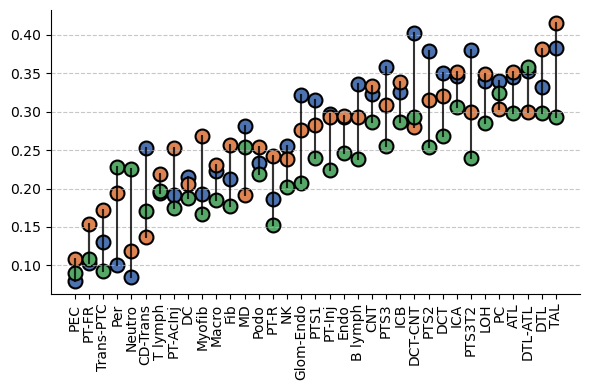

In [94]:
# Assuming your AnnData objects are named pkd_1_with_distances, pkd_2_with_distances, pkd_3_with_distances
adatas = [pkd_1_with_distances, pkd_2_with_distances, pkd_3_with_distances]
dataset_names = ['pkd_1', 'pkd_2', 'pkd_3']

# Define marker styles for each dataset
marker_styles = ['o', 'o', 'o']  # circle, square, triangle

avg_distances = []
for adata, name in zip(adatas, dataset_names):
    df = pd.DataFrame({
        'closest_cyst_distance': adata.obs['closest_cyst_distance'],
        'cluster': adata.obs['cluster']
    })
    avg_dist = df.groupby('cluster')['closest_cyst_distance'].mean().reset_index()
    avg_dist['dataset'] = name
    avg_distances.append(avg_dist)

avg_distances = pd.concat(avg_distances, ignore_index=True)

# Create a categorical type with the desired order
avg_distances['cluster'] = pd.Categorical(avg_distances['cluster'], categories=cluster_order, ordered=True)

# Sort the dataframe
avg_distances = avg_distances.sort_values(['cluster', 'dataset'])

# Set up the plot
plt.figure(figsize=(6, 4))

# Connect dots for each cell type
for cell_type in cluster_order:
    cell_data = avg_distances[avg_distances['cluster'] == cell_type]
    plt.plot(cell_data['cluster'], cell_data['closest_cyst_distance'], 'k-', alpha=0.8, color='black')

# Create scatter plot with different marker styles
for i, dataset in enumerate(dataset_names):
    data = avg_distances[avg_distances['dataset'] == dataset]
    plt.scatter(data['cluster'], data['closest_cyst_distance'], 
                label=dataset, marker=marker_styles[i], s=100, 
                linewidths=1.5, edgecolors='black', 
                c=[sns.color_palette("deep")[i]])

plt.xticks(rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
sns.despine()